In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # For debugging CUDA errors

# NDTM Code setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
import sys
sys.path.append("/home/armand/PhD/oc-guidance/models")
sys.path.append("/home/armand/PhD/oc-guidance/")
from guided_diffusion import create_model, create_model_and_diffusion, model_and_diffusion_defaults
from utils.degredations import build_degredation_model
from utils.functions import sigmoid, get_timesteps
# load and show test_image.png
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from math import prod
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
@dataclass
class DiffusionScheduleConfig:
    beta_schedule: str = 'linear'
    beta_start: float = 1e-4
    beta_end: float = 0.02
    num_diffusion_timesteps: int = 1000
    given_betas: torch.Tensor = None  # Optional, if provided, will override the schedule

class DiffusionSchedule:
    def __init__(self, hparams):
        # Instantiate the diffusion process
        if hparams.given_betas is None:
            if hparams.beta_schedule == "quad":
                betas = (
                    np.linspace(
                        hparams.beta_start**0.5,
                        hparams.beta_end**0.5,
                        hparams.num_diffusion_timesteps,
                        dtype=np.float64,
                    )
                    ** 2
                )
            elif hparams.beta_schedule == "linear":
                betas = np.linspace(
                    hparams.beta_start, hparams.beta_end, hparams.num_diffusion_timesteps, dtype=np.float64
                )
            elif hparams.beta_schedule == "const":
                betas = hparams.beta_end * np.ones(hparams.num_diffusion_timesteps, dtype=np.float64)
            elif hparams.beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
                betas = 1.0 / np.linspace(
                    hparams.num_diffusion_timesteps, 1, hparams.num_diffusion_timesteps, dtype=np.float64
                )
            elif hparams.beta_schedule == "sigmoid":
                betas = np.linspace(-6, 6, hparams.num_diffusion_timesteps)
                betas = sigmoid(betas) * (hparams.beta_end - hparams.beta_start) + hparams.beta_start
            else:
                raise NotImplementedError(hparams.beta_schedule)
            assert betas.shape == (hparams.num_diffusion_timesteps,)
            betas = torch.from_numpy(betas)
        else:
            betas = hparams.given_betas
        self.betas = torch.cat([torch.zeros(1).to(betas.device), betas], dim=0).cuda().float()
        self.alphas = (1 - self.betas).cumprod(dim=0).cuda().float()
        self.hparams = hparams

    def alpha(self, t):
        return self.alphas[t+1]
    
    def beta(self, t):
        return self.betas[t+1]

    def predict_x_from_eps(self, xt, et, t):
        alpha_t = self.alpha(t).view(-1, 1, 1, 1)
        return (xt - et * (1 - alpha_t).sqrt()) / alpha_t.sqrt()

In [3]:
class DiffusionModel:
    def __init__(self, model: nn.Module, diffusion_schedule: object, class_cond_diffusion_model=False):
        self.model = model
        self.diffusion_schedule = diffusion_schedule
        self.class_cond_diffusion_model = class_cond_diffusion_model

    def __call__(self, xt, y, t, predict_variance=False):
        y = y if self.class_cond_diffusion_model else None
        out = self.model(xt, t, y)
        et = out[:, :3]
        if not predict_variance:
            return et
        else:
            logvar = out[:, 3:]
            return et, logvar

In [4]:
class Combine_fn(ABC):
    def __init__(self, gamma_t=None):
        self.gamma_t = gamma_t

    @abstractmethod
    def forward(self, xt, ut, t=None, **kwargs):
        pass

    def __call__(self, xt, ut, t=None, **kwargs):
        return self.forward(xt, ut, t=t, **kwargs)


class Additive(Combine_fn):
    def forward(self, xt, ut, t=None, **kwargs):
        gamma_t = self.gamma_t(t) if callable(self.gamma_t) else self.gamma_t
        return xt + (gamma_t * ut if gamma_t is not None else ut)

@dataclass
class NDTMConfig:
    eta: float = 0.1
    N: int = 2  # Number of optimization steps
    gamma_t: float = 4.0  # u_t weight
    u_lr: float = 0.01  # learning rate for u_t
    combine_fn: str = "additive"  # Function to combine scores
    w_score_scheme: str = "ddim"  # Weighting scheme for score
    w_control_scheme: str = "ddim"  # Weighting scheme for score
    u_lr_scheduler: str = "linear"  # Learning rate scheduler for u_t
    init_control: str = "zero"  # Initialization scheme for u_t
    init_xT: str = "random" # Initialization scheme for x_T
    w_terminal: float = 50.0
    ancestral_sampling: bool = False  # If True, use ancestral sampling

class NDTM:
    def __init__(self, generative_model, subject_model, hparams):
        self.generative_model = generative_model
        self.diffusion = generative_model.diffusion_schedule
        self.subject_model = subject_model
        self.hparams = hparams
        self.F = self._get_combine_fn()

    def _get_combine_fn(self):
        if self.hparams.combine_fn == "additive":
            return Additive(gamma_t=self.hparams.gamma_t)

    def _get_score_weight(self, scheme, t, s, **kwargs):
        alpha_t = self.diffusion.alpha(t)
        alpha_s = self.diffusion.alpha(s)
        beta_t = self.diffusion.beta(t)
        alpha_t_im = 1 - beta_t

        if scheme == "zero":
            return torch.tensor([0.0], device=alpha_s.device)
        elif scheme == "ones":
            return torch.tensor([1.0], device=alpha_s.device) * 1.e-4
        elif scheme == "ddpm":
            return (beta_t**2) / (alpha_t_im * (1 - alpha_t))
        elif scheme == "ddim":
            c1 = (
                (1 - alpha_t / alpha_s) * (1 - alpha_s) / (1 - alpha_t)
            ).sqrt() * self.hparams.eta
            c2 = ((1 - alpha_s) - c1**2).sqrt()
            c2_ = ((alpha_s / alpha_t) * (1 - alpha_t)).sqrt()
            return (c2 - c2_) ** 2

        else:
            raise ValueError(f"Unknown scheme: {scheme}")

    def _get_control_weight(self, scheme, t, s):
        alpha_t = self.diffusion.alpha(t)
        alpha_s = self.diffusion.alpha(s)
        beta_t = self.diffusion.beta(t)
        alpha_t_im = 1 - beta_t

        if scheme == "zero":
            return torch.tensor([0.0], device=alpha_s.device)
        elif scheme == "ones":
            return torch.tensor([1.0], device=alpha_s.device) * 1.e-4
        elif scheme == "ddpm":
            return 1 / alpha_t_im
        elif scheme == "ddim":
            return alpha_t / alpha_s
        else:
            raise ValueError(f"Unknown scheme: {scheme}")

    def get_learning_rate(self, base_lr, current_step, total_steps):
        assert self.hparams.u_lr_scheduler in ["linear", "const"], \
            f"Unknown learning rate scheduler: {self.hparams.u_lr_scheduler}"
        
        if self.hparams.u_lr_scheduler == "linear":
            return base_lr * (1.0 - current_step / total_steps)
        else:  # const
            return base_lr

    def sample(self, x, y, ts, **kwargs):
        x_orig = x.clone()
        x = self.initialize(x, y, ts, **kwargs)
        y_0 = kwargs["y_0"]
        bs = x.size(0)
        xt = x

        xt = torch.zeros_like(xt)
        ss = [-1] + list(ts[:-1])
        xt_s = [xt.cpu()]
        x0_s = []
        uts = []
        scale = self.diffusion.hparams.num_diffusion_timesteps/len(ts)
        beta_start = scale * self.diffusion.hparams.beta_start
        beta_end = scale * self.diffusion.hparams.beta_end
        assert self.diffusion.hparams.beta_schedule == "linear", "Only linear schedule supported for ancestral sampling"
        given_betas = torch.linspace(
            beta_start, beta_end, len(ts), dtype=torch.float64, device=device
        )

        
        u_t = torch.zeros_like(xt)
        pbar = tqdm(enumerate(zip(reversed(ts), reversed(ss))), total=len(ts))
        for i, (ti, si) in pbar:

            t = torch.ones(bs).to(x.device).long() * ti
            s = torch.ones(bs).to(x.device).long() * si
            alpha_t = self.diffusion.alpha(t).view(-1, 1, 1, 1)
            alpha_s = self.diffusion.alpha(s).view(-1, 1, 1, 1)
            c1 = (
                (1 - alpha_t / alpha_s) * (1 - alpha_s) / (1 - alpha_t)
            ).sqrt() * self.hparams.eta
            c2 = ((1 - alpha_s) - c1**2).sqrt()

            # Initialize control and the optimizer
            u_t = self.initialize_ut(u_t, i)
            ut_clone = u_t.clone().detach()
            ut_clone.requires_grad = True
            current_lr = self.get_learning_rate(self.hparams.u_lr, i, len(ts))
            optimizer = torch.optim.Adam([ut_clone], lr=current_lr)

            # Loss weightings
            w_terminal = self.hparams.w_terminal
            w_score = self._get_score_weight(self.hparams.w_score_scheme, t, s, **kwargs)
            w_control = self._get_control_weight(self.hparams.w_control_scheme, t, s)
            time_rev_ind = len(ts) - i - 1
            beta_eff = given_betas[time_rev_ind]
            alphas = (1 - given_betas)
            alphas_cumprod = alphas.cumprod(dim=0).cuda().float()
            alphas_cumprod_prev = torch.cat((torch.ones(1, device=device), alphas_cumprod[:-1]), dim=0)

            
            ####################################################
            ############## Control Optimization ################
            ####################################################
            et = self.generative_model(xt, y, t).detach()
            for _ in range(self.hparams.N):
                if callable(self.hparams.gamma_t):
                    gamma_t = self.hparams.gamma_t(t)
                else:
                    gamma_t = self.hparams.gamma_t
                if gamma_t == 0:
                    break
                # Guided state vector
                cxt = self.F(xt, ut_clone, t=t, **kwargs)

                # Unguided and guided noise estimates
                et_control = self.generative_model(cxt, y, t)

                # Tweedie's estimate from the guided state vector
                if self.hparams.ancestral_sampling:
                    x0_pred = cxt/alphas_cumprod[time_rev_ind].sqrt() - (1/alphas_cumprod[time_rev_ind] - 1).sqrt()*et_control
                else:
                    x0_pred = self.diffusion.predict_x_from_eps(cxt, et_control, t)
                x0_pred = torch.clamp(x0_pred, -1, 1)
                score_diff = ((et - et_control) ** 2).reshape(bs, -1).sum(dim=1)
                c_score = w_score * score_diff

                # Control loss
                control_loss = (
                    ((self.F(xt, ut_clone, t=t, **kwargs) - xt) ** 2).reshape(bs, -1).sum(dim=1)
                )

                c_control = w_control * control_loss * (gamma_t**2)

                # Terminal Cost
                # c_terminal = ((y_0 - self.subject_model(x0_pred)) ** 2).reshape(bs, -1).sum(dim=1)
                c_terminal = torch.norm((y_0 - self.subject_model(x0_pred)), p=2).reshape(bs, -1).sum(dim=1)
                c_terminal = w_terminal * c_terminal

                # Aggregate Cost and optimize
                c_t = c_score + c_control + c_terminal

                # print(
                #     f"Diffusion step: {ti} Terminal Loss: {c_terminal.mean().item()} "
                #     f"Control loss: {c_control.mean().item()} Score loss: {c_score.mean().item()}"
                # )
                

                optimizer.zero_grad()
                c_t.sum().backward()
                optimizer.step()
            if self.hparams.N > 0 and gamma_t != 0:
                pbar.set_description(
                    f"Diffusion step: {ti} Terminal Loss: {c_terminal.mean().item()} "
                    f"Control loss: {c_control.mean().item()} Score loss: {c_score.mean().item()}"
            )
            ###########################################
            ############## DDIM update ################
            ###########################################
            with torch.no_grad():

                u_t = ut_clone.detach()
                cxt = self.F(xt, u_t, t=t, **kwargs)
                

                if self.hparams.ancestral_sampling:
                    et_control, log_var = self.generative_model(cxt, y, t, predict_variance=True)
                    x0_pred = cxt/alphas_cumprod[time_rev_ind].sqrt() - (1/alphas_cumprod[time_rev_ind] - 1).sqrt()*et_control
                    # x0_pred = self.diffusion.predict_x_from_eps(xt, et_control, t)
                    x0_pred = torch.clamp(x0_pred, -1, 1)
                    posterior_mean_coef1 = (
                        beta_eff * alphas_cumprod_prev[time_rev_ind].sqrt() / (1.0 - alphas_cumprod[time_rev_ind])
                    )
                    posterior_mean_coef2 = (
                        (1.0 - alphas_cumprod_prev[time_rev_ind])
                        * (1 - beta_eff).sqrt()
                        / (1.0 - alphas_cumprod[time_rev_ind])
                    )
                    xt = (
                        posterior_mean_coef1 * x0_pred
                        + posterior_mean_coef2 * cxt
                    )
                    # print(beta_eff, posterior_mean_coef1, posterior_mean_coef2, alphas_cumprod[i], alphas_cumprod_prev[i])
                    
                    if log_var.shape == et_control.shape and ti > 0:
                        if time_rev_ind > 0:
                            min_log = torch.log(
                                beta_eff * (1.0 - alphas_cumprod_prev[time_rev_ind]) / (1.0 - alphas_cumprod[time_rev_ind])
                            )
                        else:
                            min_log = torch.log(
                                beta_eff * (1.0 - alphas_cumprod_prev[time_rev_ind]) / (1.0 - alphas_cumprod[time_rev_ind])
                            )

                        max_log = torch.log(beta_eff)
                        # The log_var is [-1, 1] for [min_var, max_var].
                        frac = (log_var + 1) / 2
                        model_log_variance = frac * max_log + (1 - frac) * min_log
                        noise = torch.randn_like(xt) * (0.5*model_log_variance).exp()
                        xt = xt + noise
                else:
                    et_control = self.generative_model(cxt, y, t)
                    x0_pred = self.diffusion.predict_x_from_eps(cxt, et_control, t)
                    x0_pred = torch.clamp(x0_pred, -1, 1)
                    xt = (
                        alpha_s.sqrt() * x0_pred
                        + c1 * torch.randn_like(xt)
                        + c2 * et_control
                    )

                uts.append(u_t.cpu())

            xt_s.append(xt.cpu())
            x0_s.append(x0_pred.cpu())

        return list(reversed(xt_s)), list(reversed(x0_s))

    def initialize_ut(self, ut, i):
        init_control = self.hparams.init_control

        if init_control == "zero":  # constant zero
            return torch.zeros_like(ut)
        elif init_control == "random":  # constant random
            return torch.randn_like(ut)
    
        elif "causal" in init_control:
            if "zero" in init_control and i == 0:  # causal_zero
                return torch.zeros_like(ut)
            elif "random" in init_control and i == 0:  # causal_random
                return torch.randn_like(ut)

            else:
                return ut

    def initialize(self, x, y, ts, **kwargs):
        """
        random: Initialization with x_T ~ N(0, 1)
        guided: Initialization with x_T ~ DDPM(H^(y_0)) - Only for Linear IP
        """
        init_scheme = self.hparams.init_xT
        
        if init_scheme == "sdedit":
            n = x.size(0)
            ti = ts[-1]
            t = torch.ones(n).to(x.device).long() * ti
            alpha_t = self.diffusion.alpha(t).view(-1, 1, 1, 1)
            return x * alpha_t.sqrt() + torch.randn_like(x) * (1 - alpha_t).sqrt()
        elif init_scheme == "guided":
            raise(NotImplementedError("Guided initialization not implemented (could be useful if subject model decoder is available)"))
            y_0 = kwargs["y_0"]
            n = x.size(0)
            ti = ts[-1]
            t = torch.ones(n).to(x.device).long() * ti
            alpha_t = self.diffusion.alpha(t).view(-1, 1, 1, 1)
            return alpha_t.sqrt() * x_0 + (1 - alpha_t).sqrt() * torch.randn_like(x_0)
        else:
            return torch.randn_like(x)


In [ ]:
@torch.enable_grad()
def refine_with_gradient_descent(samples, originals, subject_model, steps=25, lr=0.01):
    samples = samples.clone().requires_grad_(True).to(device)
    optimizer = torch.optim.Adam([samples], lr=lr)
    original_embeddings = subject_model(originals.to(device)).detach()
    criterion = torch.nn.MSELoss(reduce="mean")
    subject_model.eval()
    loss_start = 0.0
    loss_end = 0.0
    
    for i in trange(steps):
        optimizer.zero_grad()
        loss = criterion(subject_model(samples), original_embeddings)
        if i == 0:
            loss_start = torch.sqrt(loss).item()
        if i == steps - 1:
            loss_end = torch.sqrt(loss).item()
        loss.backward()
        optimizer.step()

    print(f"Loss before refinement: {loss_start}, after refinement: {loss_end}")
    return samples.detach()

@torch.enable_grad()
def refine_in_ae_latent_space(samples, originals, subject_model, autoencoder, steps=25, lr=0.01):
    with torch.no_grad():
        z_samples = autoencoder.encode(samples).detach()
    z_samples = z_samples.clone().requires_grad_(True).to(device)
    optimizer = torch.optim.Adam([z_samples], lr=lr)
    original_embeddings = subject_model(originals.to(device)).detach()
    criterion = torch.nn.MSELoss(reduce="mean")
    loss_start = 0.0
    loss_end = 0.0
    
    for i in trange(steps):
        optimizer.zero_grad()
        decoded = autoencoder.decode(z_samples)
        loss = criterion(subject_model(decoded), original_embeddings)
        if i == 0:
            loss_start = torch.sqrt(loss).item()
        if i == steps - 1:
            loss_end = torch.sqrt(loss).item()
        loss.backward()
        optimizer.step()

    print(f"Loss before refinement: {loss_start}, after refinement: {loss_end}")
    return autoencode.decode(z_samples).detach().reshape(samples.shape)


# FFHQ Reproduction

In [348]:
ffhq_config = {
    "in_channels": 3,
    "out_channels": 3,
    "num_channels": 128,
    "num_heads": 4,
    "num_res_blocks": 1,
    "attention_resolutions": "16",
    "dropout": 0.0,
    "resamp_with_conv": True,
    "learn_sigma": True,
    "use_scale_shift_norm": True,
    "use_fp16": False,
    "resblock_updown": True,
    "num_heads_upsample": -1,
    "var_type": 'fixedsmall',
    "num_head_channels": 64,
    "image_size": 256,
    "class_cond": False,
    "use_new_attention_order": False,
    "ckpt": "ffhq_256",
}

diffusion_schedule_config = DiffusionScheduleConfig()
NDTM_config = NDTMConfig()

deg_config = {
    "kernel": "gaussian",
    "kernel_size": 64,
    "intensity": 3.0,
    "name": "bid",
    "lr": 0.01,
      
    "noise": { 
      "name": "gaussian",
      "sigma": 0.01,
    },
}

In [225]:
generative_model_chkpt_path = "/home/armand/PhD/FFF_fiberlearning/notebooks/GenerativeModels/ffhq_10m.pt"
base_model = create_model(**ffhq_config)
base_model.load_state_dict(torch.load(generative_model_chkpt_path, map_location=device))
base_model = base_model.to(device)

/tmp/ipykernel_3260791/2802337403.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(generative_model_chkpt_path, map_location=device)

In [226]:
diffusion_schedule = DiffusionSchedule(diffusion_schedule_config)
generative_model = DiffusionModel(base_model, diffusion_schedule, class_cond_diffusion_model=False)

In [227]:
@dataclass
class LoaderConfig:
    batch_size: int = 1
    num_workers: int = 12
    shuffle: bool =  False
    drop_last: bool = False
    pin_memory: bool = True

@dataclass
class DegredationConfig:
    kernel: str = "gaussian"
    kernel_size: int = 64
    intensity: float = 3.0
    name: str = "bid"
    lr: float = 0.01
    noise: dict = field(default_factory=lambda: {"name": "gaussian", "sigma": 0.01})

        
@dataclass
class DatasetConfig:
    name: str = "FFHQ_256x256"
    root: str = "/extra/ucibdl1/shared/data/ffhq_lmdb"
    split: str = "val"
    image_size: int = 256
    channels: int = 3
    transform: str = "default"
    subset: int = 1000
    decode_key: bool = False

@dataclass
class TimestepConfig:
    t_start: int = 0
    t_end: int = 600
    num_steps: int = 250
    seed: int = 0
    stride: str = "ddpm_uniform"
    root: str = "/path/to/experiment/root"
    name: str = "samples"
    ckpt_root: str = "/path/to/pretrained/checkpoints"
    samples_root: str = "/path/to/save/samples"
    overwrite: bool = True
    use_wandb: bool = False
    save_ori: bool = True
    save_deg: bool = True
    smoke_test: int = 1

@dataclass
class DegredationSubjectModelConfig:
    algo: str = "ndtm"
    deg: dict = field(default_factory=lambda: DegredationConfig())
    dataset: dict = field(default_factory=lambda: DatasetConfig())
    loader: dict = field(default_factory=lambda: LoaderConfig())
    exp: dict = field(default_factory=lambda: TimestepConfig())

class DegradationSubjectModel(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.degredation_model = build_degredation_model(hparams)
        
    def forward(self, x):
        return self.degredation_model.H(x)

    def decode(self, y):
        return self.degredation_model.H_pinv(y)

In [228]:
subject_model = DegradationSubjectModel(hparams=DegredationSubjectModelConfig())

ndtm
deg bid


/home/armand/PhD/oc-guidance/utils/degredations.py:1135: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  b_img[:, i, :, :] = F.conv2d(


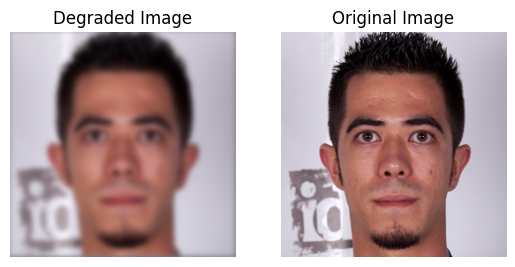

In [229]:
test_image_path = "/home/armand/ffhq_256_test_image.png"
test_image = Image.open(test_image_path).convert("RGB")
test_image = test_image.resize((256, 256))
test_image = np.array(test_image) / 255.0
test_image = torch.tensor(test_image).permute(2, 0, 1).unsqueeze(0).float().to(device) * 2 - 1  # Normalize to [-1, 1]
test_image = test_image.clamp(-1, 1)  # Ensure values are within [-1, 1]
with torch.no_grad():
    test_image_degraded = subject_model(test_image).reshape(3, 256, 256)  # Apply the degredation model
#test_image_degraded = test_image_degraded.clamp(-1, 1)  # Ensure values are within [-1, 1]
#test_image_degraded, test_image = test_image_degraded.unsqueeze(0), test_image.unsqueeze(0)

plt.subplot(1, 2, 1)
plt.imshow(test_image_degraded.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Degraded Image")
plt.subplot(1, 2, 2)
plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Original Image")
plt.show()

In [230]:
ndtm = NDTM(
    generative_model=generative_model,
    subject_model=subject_model,
    hparams=NDTM_config
)

In [231]:
ts = get_timesteps(DegredationSubjectModelConfig())
imgs_noised, imgs_approximated = ndtm.sample(test_image.to(device), None, ts, y_0 = test_image_degraded.to(device))

  0%|          | 0/300 [00:00<?, ?it/s]

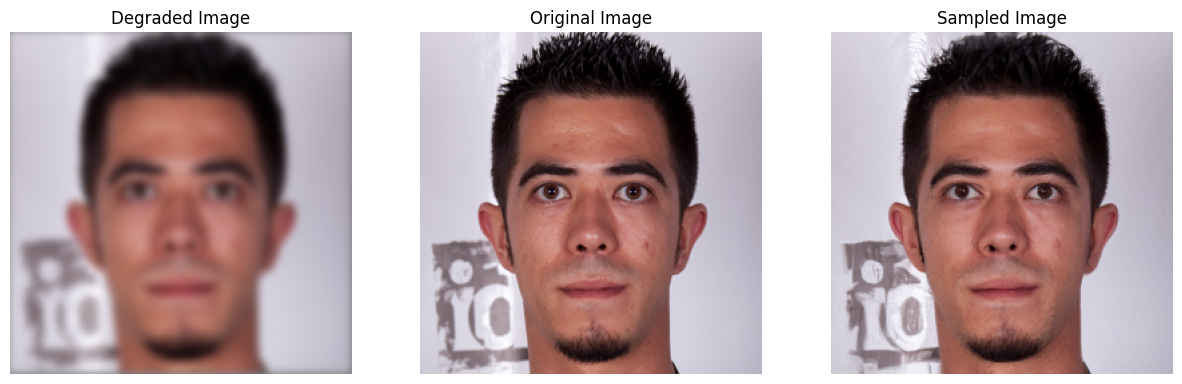

In [232]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_image_degraded.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Degraded Image")
plt.subplot(1, 3, 2)
plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1, 3, 3)
plt.imshow(imgs_noised[0].squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Sampled Image")
plt.show()

# Dino V2 subject model on FFHQ

In [736]:
ffhq_config = {
    "in_channels": 3,
    "out_channels": 3,
    "num_channels": 128,
    "num_heads": 4,
    "num_res_blocks": 1,
    "attention_resolutions": "16",
    "dropout": 0.0,
    "resamp_with_conv": True,
    "learn_sigma": True,
    "use_scale_shift_norm": True,
    "use_fp16": False,
    "resblock_updown": True,
    "num_heads_upsample": -1,
    "var_type": 'fixedsmall',
    "num_head_channels": 64,
    "image_size": 256,
    "class_cond": False,
    "use_new_attention_order": False,
    "ckpt": "ffhq_256",
}

@dataclass
class TimestepConfig:
    t_start: int = 0
    t_end: int = 1000
    num_steps: int = 100
    seed: int = 0
    stride: str = "ddpm_uniform"
    root: str = "/path/to/experiment/root"
    name: str = "samples"
    ckpt_root: str = "/path/to/pretrained/checkpoints"
    samples_root: str = "/path/to/save/samples"
    overwrite: bool = True
    use_wandb: bool = False
    save_ori: bool = True
    save_deg: bool = True
    smoke_test: int = 1

@dataclass
class NDTMTimestepCompatability:
    exp: TimestepConfig = field(default_factory=TimestepConfig)

timestep_config = NDTMTimestepCompatability()

diffusion_schedule_config = DiffusionScheduleConfig()
NDTM_config = NDTMConfig(N=5, 
                         gamma_t= lambda t: 20 if t < 400 else 1.0 / (t/600), # torch.sigmoid((800 - t)/400) * 20.0, 
                         u_lr=0.002, 
                         w_terminal=1.0, 
                         eta=1.0,
                         u_lr_scheduler="linear",
                         w_score_scheme="zero",
                         w_control_scheme="ones")

In [737]:
class DinoSubjectModel(nn.Module):
    def __init__(self, model_name='dinov2_vitb14'):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/dinov2', model_name)
        self.model.eval()  # Set to eval mode
        self.preprocess = T.Compose([
            T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
            T.CenterCrop(224),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
        
    def forward(self, x):
        x = (x+1)/2  # Scale from [-1, 1] to [0, 1]
        x = self.preprocess(x)
        return self.model(x)

    def decode(self, y):
        raise NotImplementedError("DINOv2 does not support decoding.")

In [738]:
subject_model = DinoSubjectModel().to(device)

Using cache found in /home/armand/.cache/torch/hub/facebookresearch_dinov2_main


In [739]:
generative_model_chkpt_path = "/home/armand/PhD/FFF_fiberlearning/notebooks/GenerativeModels/ffhq_10m.pt"
base_model = create_model(**ffhq_config)
base_model.load_state_dict(torch.load(generative_model_chkpt_path, map_location=device))
base_model = base_model.to(device)

/tmp/ipykernel_3328184/2802337403.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(generative_model_chkpt_path, map_location=device)

In [740]:
diffusion_schedule = DiffusionSchedule(diffusion_schedule_config)
generative_model = DiffusionModel(base_model, diffusion_schedule, class_cond_diffusion_model=False)

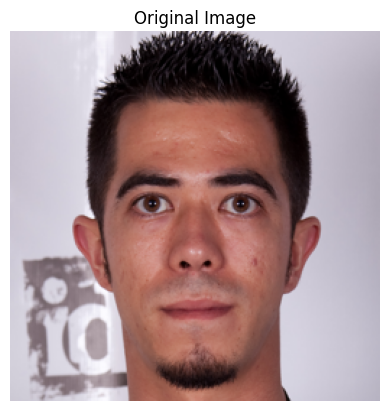

First 5 dimensions of Dino embeddings: tensor([-0.0126,  0.4392, -0.7349, -4.6978, -0.6595], device='cuda:0')


In [741]:
test_image_path = "/home/armand/ffhq_256_test_image.png"
test_image = Image.open(test_image_path).convert("RGB")
test_image = test_image.resize((256, 256))
test_image = np.array(test_image) / 255.0
test_image = torch.tensor(test_image).permute(2, 0, 1).unsqueeze(0).float().to(device) * 2 - 1  # Normalize to [-1, 1]
test_image = test_image.clamp(-1, 1)  # Ensure values are within [-1, 1]
with torch.no_grad():
    dino_features = subject_model(test_image)  # Apply the degredation model
#test_image_degraded = test_image_degraded.clamp(-1, 1)  # Ensure values are within [-1, 1]
#test_image_degraded, test_image = test_image_degraded.unsqueeze(0), test_image.unsqueeze(0)

plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Original Image")
plt.show()

print(f"First 5 dimensions of Dino embeddings: {dino_features.squeeze()[:5]}")

In [742]:
ndtm = NDTM(
    generative_model=generative_model,
    subject_model=subject_model,
    hparams=NDTM_config
)

In [743]:
ts = get_timesteps(timestep_config)
imgs_noised, imgs_approximated = ndtm.sample(test_image.to(device), None, ts, y_0 = dino_features.to(device))

  0%|          | 0/100 [00:00<?, ?it/s]

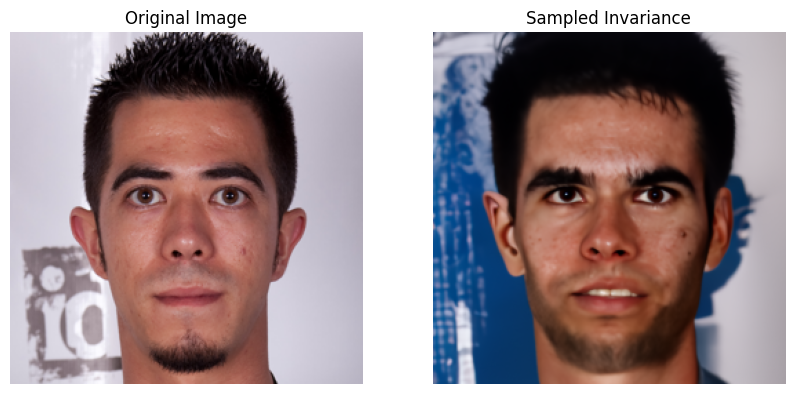

In [744]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(imgs_noised[0].squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Sampled Invariance")
plt.show()

In [745]:
dino_features_new = subject_model(imgs_noised[0].to(device))
print(f"Difference in Dino features: {torch.norm(dino_features - dino_features_new)/prod(dino_features.size())}")

Difference in Dino features: 0.009016074240207672


# ArcFace subject model on FFHQ

In [49]:
ffhq_config = {
    "in_channels": 3,
    "out_channels": 3,
    "num_channels": 128,
    "num_heads": 4,
    "num_res_blocks": 1,
    "attention_resolutions": "16",
    "dropout": 0.0,
    "resamp_with_conv": True,
    "learn_sigma": True,
    "use_scale_shift_norm": True,
    "use_fp16": False,
    "resblock_updown": True,
    "num_heads_upsample": -1,
    "var_type": 'fixedsmall',
    "num_head_channels": 64,
    "image_size": 256,
    "class_cond": False,
    "use_new_attention_order": False,
    "ckpt": "ffhq_256",
}

@dataclass
class TimestepConfig:
    t_start: int = 0
    t_end: int = 1000
    num_steps: int = 100
    seed: int = 0
    stride: str = "ddpm_uniform"
    root: str = "/path/to/experiment/root"
    name: str = "samples"
    ckpt_root: str = "/path/to/pretrained/checkpoints"
    samples_root: str = "/path/to/save/samples"
    overwrite: bool = True
    use_wandb: bool = False
    save_ori: bool = True
    save_deg: bool = True
    smoke_test: int = 1

@dataclass
class NDTMTimestepCompatability:
    exp: TimestepConfig = field(default_factory=TimestepConfig)

timestep_config = NDTMTimestepCompatability()

diffusion_schedule_config = DiffusionScheduleConfig()
NDTM_config = NDTMConfig(N=3, 
                         gamma_t= lambda t: 20 if t < 400 else 1.0 / (t/600), # torch.sigmoid((800 - t)/400) * 20.0, 
                         u_lr=0.002, 
                         w_terminal=1.0, 
                         eta=1.0,
                         u_lr_scheduler="linear",
                         w_score_scheme="zero",
                         w_control_scheme="ones")

In [50]:
sys.path.append("/home/armand/InsightFace_Pytorch")
from model import Backbone

class ArcFaceSubjectModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = Backbone(50, 0, 'ir_se').to(device)
        self.model.eval()  # Set to eval mode
        # Load pre-trained weights
        arcface_weights_path = "SubjectModels/model_ir_se50.pth"
        if os.path.exists(arcface_weights_path):
            self.model.load_state_dict(torch.load(arcface_weights_path, map_location=device))
        self.preprocess = T.Compose([
            T.Resize(128, interpolation=T.InterpolationMode.BICUBIC),
            T.CenterCrop(112),
            T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        
    def forward(self, x):
        x = (x+1)/2  # Scale from [-1, 1] to [0, 1]
        x = self.preprocess(x).contiguous()
        return self.model(x)

    def decode(self, y):
        raise NotImplementedError("ArcFace does not support decoding.")

In [51]:
subject_model = ArcFaceSubjectModel().to(device)

/tmp/ipykernel_3660684/2126279334.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(arcface_weights_path, map_location=device))


In [52]:
generative_model_chkpt_path = "/home/armand/PhD/FFF_fiberlearning/notebooks/GenerativeModels/ffhq_10m.pt"
base_model = create_model(**ffhq_config)
base_model.load_state_dict(torch.load(generative_model_chkpt_path, map_location=device))
base_model = base_model.to(device)

/tmp/ipykernel_3660684/2802337403.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(generative_model_chkpt_path, map_location=device)

In [53]:
diffusion_schedule = DiffusionSchedule(diffusion_schedule_config)
generative_model = DiffusionModel(base_model, diffusion_schedule, class_cond_diffusion_model=False)

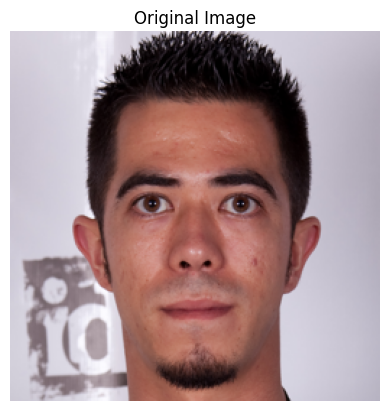

First 5 dimensions of ArcFace embeddings: tensor([-0.0011, -0.0280, -0.0447, -0.0074, -0.0002], device='cuda:0')


In [54]:
test_image_path = "/home/armand/ffhq_256_test_image.png"
test_image = Image.open(test_image_path).convert("RGB")
test_image = test_image.resize((256, 256))
test_image = np.array(test_image) / 255.0
test_image = torch.tensor(test_image).permute(2, 0, 1).unsqueeze(0).float().to(device) * 2 - 1  # Normalize to [-1, 1]
test_image = test_image.clamp(-1, 1)  # Ensure values are within [-1, 1]
with torch.no_grad():
    dino_features = subject_model(test_image)  # Apply the degredation model
#test_image_degraded = test_image_degraded.clamp(-1, 1)  # Ensure values are within [-1, 1]
#test_image_degraded, test_image = test_image_degraded.unsqueeze(0), test_image.unsqueeze(0)

plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Original Image")
plt.show()

print(f"First 5 dimensions of ArcFace embeddings: {dino_features.squeeze()[:5]}")

In [55]:
ndtm = NDTM(
    generative_model=generative_model,
    subject_model=subject_model,
    hparams=NDTM_config
)

In [56]:
ts = get_timesteps(timestep_config)
imgs_noised, imgs_approximated = ndtm.sample(test_image.to(device), None, ts, y_0 = dino_features.to(device))

  0%|          | 0/100 [00:00<?, ?it/s]

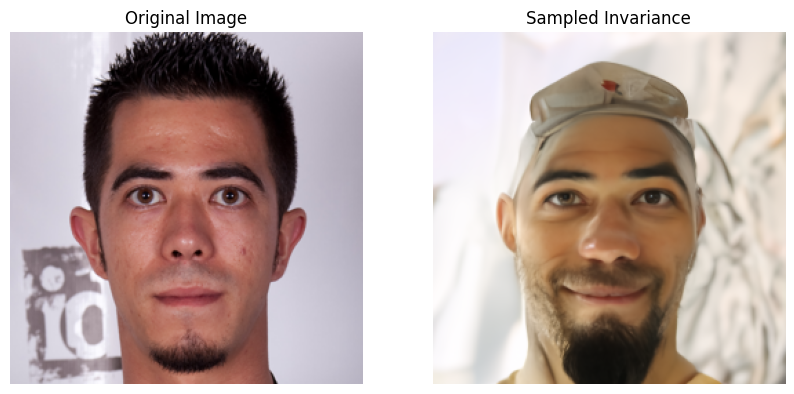

In [57]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(imgs_noised[0].squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Sampled Invariance")
plt.show()

In [58]:
dino_features_new = subject_model(imgs_noised[0].to(device))
print(f"Difference in ArcFace features: {torch.norm(dino_features - dino_features_new)/prod(dino_features.size())}")

Difference in ArcFace features: 0.0009879438439384103


# Ancestral Sampling + Dino V2 subject model on FFHQ

In [908]:
ffhq_config = {
    "in_channels": 3,
    "out_channels": 3,
    "num_channels": 128,
    "num_heads": 4,
    "num_res_blocks": 1,
    "attention_resolutions": "16",
    "dropout": 0.0,
    "resamp_with_conv": True,
    "learn_sigma": True,
    "use_scale_shift_norm": True,
    "use_fp16": False,
    "resblock_updown": True,
    "num_heads_upsample": -1,
    "var_type": 'fixedsmall',
    "num_head_channels": 64,
    "image_size": 256,
    "class_cond": False,
    "use_new_attention_order": False,
    "ckpt": "ffhq_256",
}

@dataclass
class TimestepConfig:
    t_start: int = 0
    t_end: int = 1000
    num_steps: int = 200
    seed: int = 0
    stride: str = "ddpm_uniform"
    root: str = "/path/to/experiment/root"
    name: str = "samples"
    ckpt_root: str = "/path/to/pretrained/checkpoints"
    samples_root: str = "/path/to/save/samples"
    overwrite: bool = True
    use_wandb: bool = False
    save_ori: bool = True
    save_deg: bool = True
    smoke_test: int = 1

@dataclass
class NDTMTimestepCompatability:
    exp: TimestepConfig = field(default_factory=TimestepConfig)

timestep_config = NDTMTimestepCompatability()



diffusion_schedule_config = DiffusionScheduleConfig()# given_betas=given_betas)
NDTM_config = NDTMConfig(N=5, 
                         gamma_t= lambda t: 20 * (600 - t)/600 if t < 600 else 0.0, # torch.sigmoid((800 - t)/400) * 20.0, 
                         u_lr=0.002, 
                         w_terminal=1.0, 
                         eta=1.0,
                         u_lr_scheduler="linear",
                         w_score_scheme="zero",
                         w_control_scheme="ones",
                         ancestral_sampling=True  # Enable ancestral sampling
                         )

In [909]:
class DinoSubjectModel(nn.Module):
    def __init__(self, model_name='dinov2_vitb14'):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/dinov2', model_name)
        self.model.eval()  # Set to eval mode
        self.preprocess = T.Compose([
            T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
            T.CenterCrop(224),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
        
    def forward(self, x):
        x = (x+1)/2  # Scale from [-1, 1] to [0, 1]
        x = self.preprocess(x)
        return self.model(x)

    def decode(self, y):
        raise NotImplementedError("DINOv2 does not support decoding.")

In [910]:
subject_model = DinoSubjectModel().to(device)

Using cache found in /home/armand/.cache/torch/hub/facebookresearch_dinov2_main


In [911]:
generative_model_chkpt_path = "/home/armand/PhD/FFF_fiberlearning/notebooks/GenerativeModels/ffhq_10m.pt"
base_model = create_model(**ffhq_config)
base_model.load_state_dict(torch.load(generative_model_chkpt_path, map_location=device))
base_model = base_model.to(device)

/tmp/ipykernel_3328184/2802337403.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(generative_model_chkpt_path, map_location=device)

In [912]:
diffusion_schedule = DiffusionSchedule(diffusion_schedule_config)
generative_model = DiffusionModel(base_model, diffusion_schedule, class_cond_diffusion_model=False)

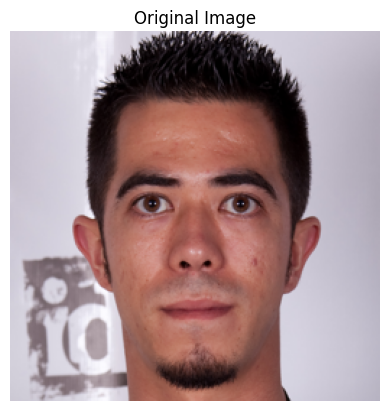

First 5 dimensions of Dino embeddings: tensor([-0.0126,  0.4392, -0.7349, -4.6978, -0.6595], device='cuda:0')


In [913]:
test_image_path = "/home/armand/ffhq_256_test_image.png"
test_image = Image.open(test_image_path).convert("RGB")
test_image = test_image.resize((256, 256))
test_image = np.array(test_image) / 255.0
test_image = torch.tensor(test_image).permute(2, 0, 1).unsqueeze(0).float().to(device) * 2 - 1  # Normalize to [-1, 1]
test_image = test_image.clamp(-1, 1)  # Ensure values are within [-1, 1]
with torch.no_grad():
    dino_features = subject_model(test_image)  # Apply the degredation model
#test_image_degraded = test_image_degraded.clamp(-1, 1)  # Ensure values are within [-1, 1]
#test_image_degraded, test_image = test_image_degraded.unsqueeze(0), test_image.unsqueeze(0)

plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Original Image")
plt.show()

print(f"First 5 dimensions of Dino embeddings: {dino_features.squeeze()[:5]}")

In [914]:
ndtm = NDTM(
    generative_model=generative_model,
    subject_model=subject_model,
    hparams=NDTM_config
)

In [915]:
ts = get_timesteps(timestep_config)
imgs_noised, imgs_approximated = ndtm.sample(test_image.to(device), None, ts, y_0 = dino_features.to(device))

  0%|          | 0/200 [00:00<?, ?it/s]

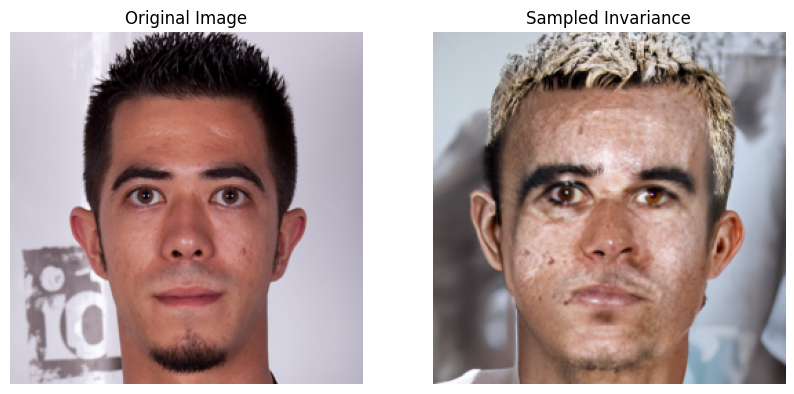

In [916]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(imgs_noised[0].squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Sampled Invariance")
plt.show()

In [917]:
dino_features_new = subject_model(imgs_noised[0].to(device))
print(f"Difference in Dino features: {torch.norm(dino_features - dino_features_new)/prod(dino_features.size())}")

Difference in Dino features: 0.009096622467041016


# Dino V2 on ImageNet

In [5]:
imagenet_config = {
    "in_channels": 3,
    "out_channels": 3,
    "num_channels": 256,
    "num_heads": 4,
    "num_res_blocks": 2,
    "attention_resolutions": "32,16,8",
    "dropout": 0.0,
    "resamp_with_conv": True,
    "learn_sigma": True,
    "use_scale_shift_norm": True,
    "use_fp16": True,
    "resblock_updown": True,
    "num_heads_upsample": -1,
    "var_type": 'fixedsmall',
    "num_head_channels": 64,
    "image_size": 256,
    "class_cond": False,
    "use_checkpoint": True,
    "use_new_attention_order": False,
    "ckpt": "imagenet_256_uncond",
}

@dataclass
class TimestepConfig:
    t_start: int = 0
    t_end: int = 1000
    num_steps: int = 100
    seed: int = 0
    stride: str = "ddpm_uniform"
    root: str = "/path/to/experiment/root"
    name: str = "samples"
    ckpt_root: str = "/path/to/pretrained/checkpoints"
    samples_root: str = "/path/to/save/samples"
    overwrite: bool = True
    use_wandb: bool = False
    save_ori: bool = True
    save_deg: bool = True
    smoke_test: int = 1

@dataclass
class NDTMTimestepCompatability:
    exp: TimestepConfig = field(default_factory=TimestepConfig)

timestep_config = NDTMTimestepCompatability()

diffusion_schedule_config = DiffusionScheduleConfig()
NDTM_config = NDTMConfig(N=5, 
                         gamma_t= lambda t: 20 if t < 400 else 1.0 / (t/600), # torch.sigmoid((800 - t)/400) * 20.0, 
                         u_lr=0.002, 
                         w_terminal=1.0, 
                         eta=1.0,
                         u_lr_scheduler="linear",
                         w_score_scheme="zero",
                         w_control_scheme="ones")

In [6]:
class DinoSubjectModel(nn.Module):
    def __init__(self, model_name='dinov2_vitb14'):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/dinov2', model_name)
        self.model.eval()  # Set to eval mode
        self.preprocess = T.Compose([
            T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
            T.CenterCrop(224),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
        
    def forward(self, x):
        x = (x+1)/2  # Scale from [-1, 1] to [0, 1]
        x = self.preprocess(x)
        return self.model(x)

    def decode(self, y):
        raise NotImplementedError("DINOv2 does not support decoding.")

In [7]:
subject_model = DinoSubjectModel().to(device)

Using cache found in /home/armand/.cache/torch/hub/facebookresearch_dinov2_main
/home/armand/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/armand/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/armand/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [8]:
generative_model_chkpt_path = "/home/armand/PhD/FFF_fiberlearning/notebooks/GenerativeModels/256x256_diffusion_uncond.pt"
base_model = create_model(**imagenet_config)
base_model.load_state_dict(torch.load(generative_model_chkpt_path, map_location=device))
base_model = base_model.to(device)

/tmp/ipykernel_3340465/4191126922.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(generative_model_chkpt_path, map_location=device)

In [9]:
diffusion_schedule = DiffusionSchedule(diffusion_schedule_config)
generative_model = DiffusionModel(base_model, diffusion_schedule, class_cond_diffusion_model=False)

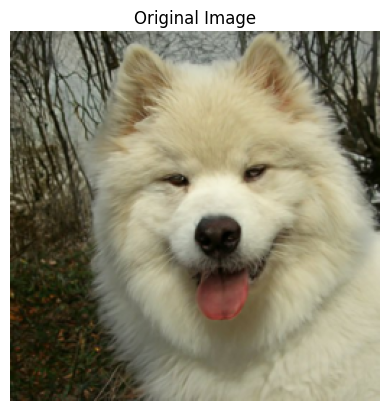

First 5 dimensions of Dino embeddings: tensor([ 2.9485, -0.4297, -1.5380,  2.2593, -0.8466], device='cuda:0')


In [11]:
test_image_path = "/home/armand/imagenet_256_test_image.jpg"
test_image = Image.open(test_image_path).convert("RGB")
test_image = test_image.resize((256, 256))
test_image = np.array(test_image) / 255.0
test_image = torch.tensor(test_image).permute(2, 0, 1).unsqueeze(0).float().to(device) * 2 - 1  # Normalize to [-1, 1]
test_image = test_image.clamp(-1, 1)  # Ensure values are within [-1, 1]
with torch.no_grad():
    dino_features = subject_model(test_image)  # Apply the degredation model
#test_image_degraded = test_image_degraded.clamp(-1, 1)  # Ensure values are within [-1, 1]
#test_image_degraded, test_image = test_image_degraded.unsqueeze(0), test_image.unsqueeze(0)

plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Original Image")
plt.show()

print(f"First 5 dimensions of Dino embeddings: {dino_features.squeeze()[:5]}")

In [12]:
ndtm = NDTM(
    generative_model=generative_model,
    subject_model=subject_model,
    hparams=NDTM_config
)

In [13]:
ts = get_timesteps(timestep_config)
imgs_noised, imgs_approximated = ndtm.sample(test_image.to(device), None, ts, y_0 = dino_features.to(device))

  0%|          | 0/100 [00:00<?, ?it/s]

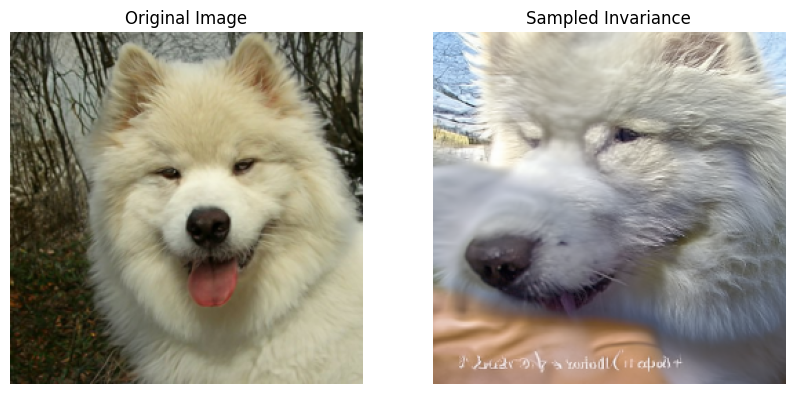

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(imgs_noised[0].squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Sampled Invariance")
plt.show()

In [15]:
dino_features_new = subject_model(imgs_noised[0].to(device))
print(f"Difference in Dino features: {torch.norm(dino_features - dino_features_new)/prod(dino_features.size())}")

Difference in Dino features: 0.007227353285998106


# CT Image Invariances

## LoRA Training

In [1]:
# train_lora_stable_diffusion.py

import torch
from torch.utils.data import DataLoader
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel
from accelerate import Accelerator
from tqdm import tqdm
from peft import get_peft_model, LoraConfig, TaskType
from transformers import CLIPTextModel, CLIPTokenizer
from fff.data import load_dataset  # your custom loader
from collections import deque
from torch.optim.lr_scheduler import OneCycleLR

def train_lora_sd(
    data_set_config: dict,
    pretrained_model_name="runwayml/stable-diffusion-v1-5",
    image_size=256,
    batch_size=4,
    lr=1e-4,
    num_epochs=10,
    save_path="./lora_ct_model"
):
    accelerator = Accelerator()
    device = accelerator.device

    # Load dataset
    train_ds, val_ds, _ = load_dataset(**data_set_config)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

    # Load pretrained pipeline
    pipe = StableDiffusionPipeline.from_pretrained(pretrained_model_name, torch_dtype=torch.float16).to(device)
    vae = pipe.vae
    unet = pipe.unet
    tokenizer = pipe.tokenizer
    text_encoder = pipe.text_encoder
    noise_scheduler = pipe.scheduler

    # Set to eval mode (only UNet is trained)
    vae.eval()
    text_encoder.eval()
    for p in vae.parameters(): p.requires_grad = False
    for p in text_encoder.parameters(): p.requires_grad = False

    # Prepare UNet with LoRA
    lora_config = LoraConfig(
        r=8,
        lora_alpha=32,
        target_modules=["to_q", "to_k", "to_v", "to_out.0", "conv1", "conv2", "proj_in", "proj_out"],
        bias="none",
    )
    unet = get_peft_model(unet, lora_config)

    # Optimizer
    total_steps = num_epochs*len(train_loader)
    optimizer = torch.optim.AdamW(unet.parameters(), lr=lr)
    lr_scheduler = OneCycleLR(optimizer, max_lr=lr, total_steps=total_steps)
    # Prepare everything with accelerate
    unet, optimizer, train_loader = accelerator.prepare(unet, optimizer, train_loader)
    loss_window = deque(maxlen=100)  # moving average over last 100 batches


    unet.train()
    for epoch in range(num_epochs):
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", dynamic_ncols=True, leave=False)
        for i, batch in enumerate(pbar):
            images = batch[0].to(device).half().reshape(batch_size, 1, image_size, image_size)
            images = images.repeat(1, 3, 1, 1)  # Stable Diffusion expects 3 channels
            
            # Encode to latents using VAE
            with torch.no_grad():
                latents = vae.encode(images * 2 - 1).latent_dist.sample() * 0.18215

            noise = torch.randn_like(latents, dtype=torch.float16)
            timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Use dummy prompt (no conditioning, or optionally "a CT image")
            input_ids = tokenizer(["a CT image"] * latents.size(0), return_tensors="pt", padding=True).input_ids.to(device)
            with torch.no_grad():
                encoder_hidden_states = text_encoder(input_ids)[0]

            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
            loss = torch.nn.functional.mse_loss(noise_pred, noise)
            accelerator.backward(loss)
            torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm=1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            loss_window.append(loss.item())
            avg_loss = sum(loss_window) / len(loss_window)
            pbar.set_postfix(avg_loss=f"{avg_loss:.4f}")

        # Save LoRA adapters
        if accelerator.is_main_process and epoch == num_epochs -1:
            unet.save_pretrained(f"{save_path}/epoch_{epoch+1}")

    print("✅ LoRA fine-tuning complete.")

2025-07-11 00:56:33.858765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO: Using pytorch backend


In [2]:
data_set_config = {
    "name": "ldct",
    "root": "/mnt/SSD_2TB/ldct_data",
    "condition": "lowdose",
    "data": "highdose",
    "patchsize": 512,
    "resize_to": 224,
    "augment": True,
    "data_norm":"minmax",
    # "data_subset": 0.0000824
}

lora_config = {
    "data_set_config": data_set_config,
    "image_size": data_set_config["resize_to"],
    "batch_size": 8,
    "lr": 1e-4,
    "num_epochs": 100,
    "save_path": "./GenerativeModels/lora_ct_model",
    "pretrained_model_name": "runwayml/stable-diffusion-v1-5",
}

In [3]:
train_lora_sd(**lora_config)

/home/armand/miniconda3/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✅ LoRA fine-tuning complete.


In [5]:
from diffusers import StableDiffusionPipeline
from peft import PeftModel
import torch

# Load the base Stable Diffusion pipeline (with safety checker disabled)
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")
pipe.unet = PeftModel.from_pretrained(pipe.unet, "./GenerativeModels/lora_ct_model/epoch_100").to("cuda")
# Set eval mode and disable gradients
pipe.unet.eval()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): lora.Conv2d(
                (base_layer): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Conv2d(320, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
          

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
tensor(0.) tensor(0.)


/home/armand/miniconda3/lib/python3.10/site-packages/diffusers/image_processor.py:148: RuntimeWarning: invalid value encountered in cast
  images = (images * 255).round().astype("uint8")


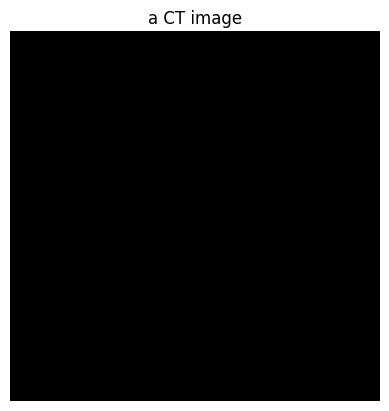

In [6]:
import matplotlib.pyplot as plt
import torchvision


with torch.no_grad():
    # Generate a CT image
    prompt = "a CT image"
    image = pipe(prompt, num_inference_steps=50,  height=224, width=224).images[0]  # PIL Image
print(torchvision.transforms.functional.pil_to_tensor(image))
image = torchvision.transforms.functional.pil_to_tensor(image).float() / 255.0  # Convert to tensor and normalize to [0, 1]
print(image.min(), image.max())  # Check min and max values
# Show image
plt.imshow(image.mean(dim=0), cmap="gray")  # or remove cmap="gray" for RGB images
plt.axis("off")
plt.title(prompt)
plt.show()



tensor(-0.0269, device='cuda:0', dtype=torch.float16) tensor(0.5684, device='cuda:0', dtype=torch.float16)


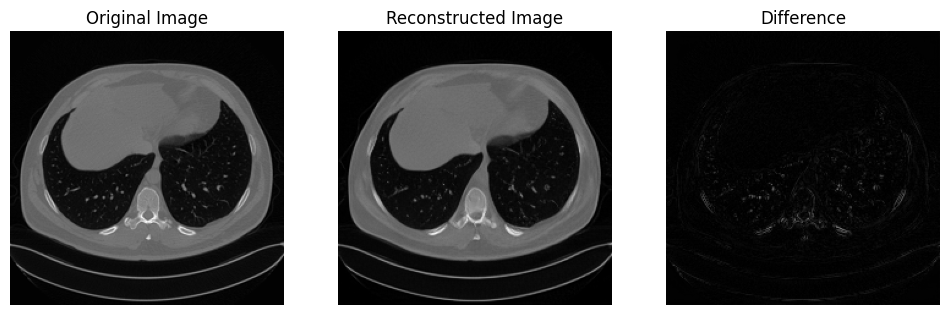

In [10]:
from torch.utils.data import DataLoader
from fff.data import load_dataset  # your custom loader

train_ds, _, _ = load_dataset(**data_set_config)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=False)
batch = next(iter(train_loader))[0]
images = batch[0].to("cuda").half().reshape(1, 1, 224, 224)
images = images.repeat(1, 3, 1, 1)
# Encode to latents using VAE
with torch.no_grad():
    reconstructed_images = pipe.vae.decode(pipe.vae.encode(images * 2 - 1).latent_dist.sample()).sample / 2 + 0.5  # Normalize to [0, 1]
    print(reconstructed_images.min(), reconstructed_images.max())  # Check min and max valuesrecon = pipe.vae.decode(pipe.vae.encode(image * 2 - 1).latent_dist.sample() * 0.18215).sample
    # latents = pipe.vae.encode(images * 2 - 1).latent_dist.sample()
    # reconstructed_images = pipe.vae.decode(latents).sample / 2 + 0.5

x0 = images[0].mean(dim=0)
x1 = reconstructed_images[0].mean(dim=0)
vmin = x0.min().item()
vmax = x0.max().item()
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(x0.float().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(x1.float().cpu().numpy(), cmap="gray", vmin=vmin, vmax=vmax)
plt.title("Reconstructed Image")
plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(torch.abs(x0 - x1).float().cpu().numpy(), cmap="gray", vmin=0, vmax=(vmax-vmin))
plt.title("Difference")

plt.show()

In [11]:
pipe.vae.encode(images * 2 - 1).latent_dist.sample() *0.18215

tensor([[[[-0.9380, -1.1357, -1.2734,  ..., -1.3477, -1.1865, -1.1914],
          [-1.1982, -1.5059, -1.3691,  ..., -1.5879, -1.4277, -1.3662],
          [-1.4717, -1.5029, -1.7363,  ..., -0.8896, -1.1455, -1.7490],
          ...,
          [-1.5342, -0.6313,  0.1576,  ..., -1.2676, -0.4656, -1.2139],
          [-1.5459, -1.3906, -1.5996,  ..., -1.5225, -1.2734, -1.7451],
          [-1.1797, -1.4287, -1.4346,  ..., -1.4375, -1.5293, -1.1602]],

         [[-2.1738, -2.3516, -2.2051,  ..., -2.2500, -2.3184, -2.0352],
          [-2.4824, -2.5020, -2.3828,  ..., -2.4453, -2.5156, -2.5039],
          [-2.4297, -2.3574, -2.0605,  ..., -1.7021, -2.5586, -2.3613],
          ...,
          [-2.3047, -1.6875, -0.6177,  ..., -1.8242, -2.1270, -2.7812],
          [-2.4570, -2.7344, -1.8672,  ..., -1.8623, -3.0332, -2.2695],
          [-2.6660, -2.3652, -2.7559,  ..., -2.7207, -2.5684, -2.2051]],

         [[ 0.5371,  0.6558,  0.9663,  ...,  0.7002,  0.8828,  0.8760],
          [ 0.6504,  1.3203,  

2025-07-10 22:20:08.074798: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-10 22:20:08.112207: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-10 22:20:08.825639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/armand/miniconda3/lib/python3.10/site-packages/peft/tuners/lora/model.py:367: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  return getattr(self.model, name)


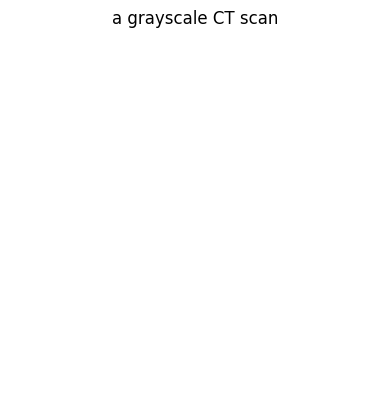

In [1]:
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from peft import PeftModel
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

device = "cuda"

# --- 1. Load Components ---
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to(device).eval()
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet").to(device).eval()
tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="text_encoder").to(device).eval()

# Optional: Load LoRA on top of UNet
unet = PeftModel.from_pretrained(unet, "./GenerativeModels/lora_ct_model/epoch_10").to(device).eval()

# --- 2. Create Scheduler ---
scheduler = LMSDiscreteScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

# --- 3. Tokenize Prompt ---
prompt = "a grayscale CT scan"
text_input = tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt")
with torch.no_grad():
    text_embeds = text_encoder(text_input.input_ids.to(device))[0]

# --- 4. Prepare Latent Noise ---
batch_size = 1
height = 224
width = 224
latents_shape = (batch_size, unet.in_channels, height // 8, width // 8)
latents = torch.randn(latents_shape, device=device)

# Match SD expectations
latents = latents * scheduler.init_noise_sigma

# --- 5. Denoising Loop ---
scheduler.set_timesteps(50)
for t in scheduler.timesteps:
    latent_model_input = latents
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeds).sample

    latents = scheduler.step(noise_pred, t, latents).prev_sample

# --- 6. Save Intermediate Latents (optional) ---
vae_latents = latents / 0.18215  # undo latent scaling
torch.save(vae_latents, "final_latents.pt")

# --- 7. Decode with VAE ---
with torch.no_grad():
    image = vae.decode(vae_latents).sample  # output in [-1, 1]

# --- 8. Convert to PIL and Show ---
image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).squeeze().numpy()
plt.imshow(image.mean(axis=-1), cmap="gray")
plt.axis("off")
plt.title(prompt)
plt.show()


In [12]:
vae_latents - pipe.vae.encode(images * 2 - 1).latent_dist.sample() *0.18215

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, 

## Training from Scratch

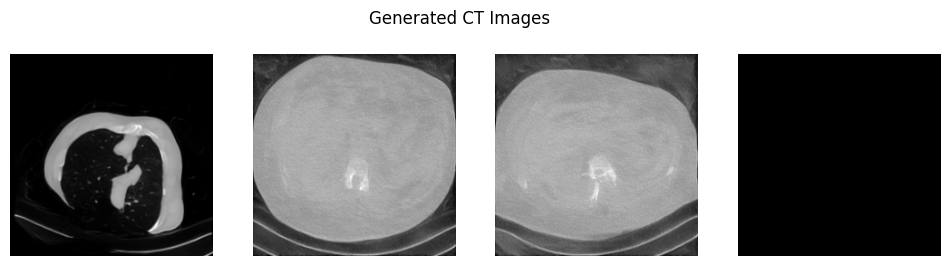

In [3]:
import torch
from diffusers import UNet2DModel, DDPMScheduler
import matplotlib.pyplot as plt

# Paths
model_path = "../scripts/saved_models/epoch_21"  # Path to trained model checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = UNet2DModel.from_pretrained(model_path).to(device)
model.eval()

# Load scheduler (make sure it's consistent with training)
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")

# Sampling config
num_inference_steps = 250  # Faster than training time
scheduler.set_timesteps(num_inference_steps)

# Sample shape: (B, C, H, W)
image_size = model.config.sample_size
batch_size = 4
samples = torch.randn((batch_size, 1, image_size, image_size)).to(device)

# Run reverse diffusion
with torch.no_grad():
    for t in scheduler.timesteps:
        # Predict noise
        noise_pred = model(samples, t).sample
        if torch.isnan(noise_pred).any():
            print(f"NaN in noise_pred at t={t}")
        # Denoise step
        samples = scheduler.step(noise_pred, t, samples).prev_sample
        # print(f"t={t} → min={samples.min().item():.3f}, max={samples.max().item():.3f}")
# Move to CPU and convert to numpy
samples = samples.cpu().clamp(0, 1)  # Values should be in [0, 1] range

# Plot
fig, axs = plt.subplots(1, batch_size, figsize=(12, 3))
for i in range(batch_size):
    axs[i].imshow(samples[i, 0], cmap="gray")
    axs[i].axis("off")
plt.suptitle("Generated CT Images")
plt.show()


## NDTM integration

In [ ]:
@dataclass
class TimestepConfig:
    t_start: int = 0
    t_end: int = 1000
    num_steps: int = 100
    seed: int = 0
    stride: str = "ddpm_uniform"
    root: str = "/path/to/experiment/root"
    name: str = "samples"
    ckpt_root: str = "/path/to/pretrained/checkpoints"
    samples_root: str = "/path/to/save/samples"
    overwrite: bool = True
    use_wandb: bool = False
    save_ori: bool = True
    save_deg: bool = True
    smoke_test: int = 1

@dataclass
class NDTMTimestepCompatability:
    exp: TimestepConfig = field(default_factory=TimestepConfig)

timestep_config = NDTMTimestepCompatability()

diffusion_schedule_config = DiffusionScheduleConfig()
NDTM_config = NDTMConfig(N=0, 
                         gamma_t= lambda t: 20 if t < 400 else 1.0 / (t/600), # torch.sigmoid((800 - t)/400) * 20.0, 
                         u_lr=0.002, 
                         w_terminal=1.0, 
                         eta=1.0,
                         u_lr_scheduler="linear",
                         w_score_scheme="zero",
                         w_control_scheme="ones")

In [ ]:
class StableDiffusionInterface:
    def __init__(self, model_path):
        self.model = UNet2DModel.from_pretrained(model_path).to(device)
        self.model.eval()

    def forward(self, x, t, y=None):
        # Assuming y is not used in this case
        noise_pred = self.model(x, t).sample
        return noise_pred


In [ ]:
generative_model_chkpt_path = "/home/armand/PhD/FFF_fiberlearning/scripts/saved_models/epoch_20"
base_model = StableDiffusionInterface(generative_model_chkpt_path)

In [226]:
diffusion_schedule = DiffusionSchedule(diffusion_schedule_config)
generative_model = DiffusionModel(base_model, diffusion_schedule, class_cond_diffusion_model=False)

In [ ]:
from fff.subject_model import SubjectModel

class BiomedClipSubjectModel(SubjectModel):
    def __init__(self,
                 subject_model_path="SubjectModels/saved_models/BiomedClip.pt",
                 model_type="PrecompiledModel",
                 ):
        super().__init__(subject_model_path=subject_model_path, model_type=model_type)

In [ ]:
subject_model = BiomedClipSubjectModel()

In [ ]:
from fff.data import load_dataset
data_set_config = {
    "name": "ldct",
    "root": "/mnt/SSD_2TB/ldct_data",
    "condition": "lowdose",
    "data": "highdose",
    "patchsize": 512,
    "resize_to": 224,
    "augment": True,
    "data_norm":"minmax",
}
val_ds, _, _ = load_dataset(**data_set_config)
test_image = val_ds[0][0].unsqueeze(0).to(device)  # Get first image from validation set

with torch.no_grad():
    test_image_embedding = subject_model(test_image) # Apply the degredation model
#test_image_degraded = test_image_degraded.clamp(-1, 1)  # Ensure values are within [-1, 1]
#test_image_degraded, test_image = test_image_degraded.unsqueeze(0), test_image.unsqueeze(0)

plt.figure(figsize=(5, 5))
plt.imshow(test_image.squeeze(), cmap="gray")
plt.axis('off')
plt.title("Original Image")
plt.show()

In [230]:
ndtm = NDTM(
    generative_model=generative_model,
    subject_model=subject_model,
    hparams=NDTM_config
)

In [231]:
ts = get_timesteps(NDTMTimestepCompatability())
imgs_noised, imgs_approximated = ndtm.sample(test_image.to(device), None, ts, y_0 = test_image_embedding.to(device))

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image.squeeze().cpu().numpy())
plt.axis('off')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(imgs_noised[0].squeeze().cpu().numpy())
plt.axis('off')
plt.title("Sampled Image")
plt.show()